In [48]:
# import pandas as pd
# import numpy as np
# import geopandas as gpd
import matplotlib.pyplot as plt; 
%matplotlib inline
# from shapely.geometry import Point, Polygon, box

## Area

In [49]:
from shapely.geometry import box
import geopandas as gpd

xmin=0; ymin=0; xmax=1000; ymax=1000
rect = box(xmin, ymin, xmax, ymax)
area1 = gpd.GeoDataFrame({'area_name':['area1'],
                          'visibility': [0.90],
                          'geometry': rect}, 
                         geometry='geometry'
                        )
area1

,area_name,visibility,geometry
0,area1,0.9,"POLYGON ((1000 0, 1000 1000, 0 1000, 0 0, 1000..."


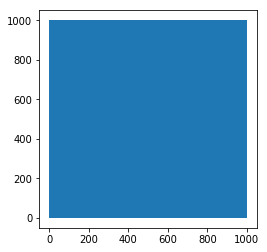

In [50]:
area1.plot()

## Coverage

### Transects

maximize for the longest single transect?
maximize for total survey area? need to buffer before calculating this

In [51]:
def make_transects(transect_interval, sweep_width, angle_degrees, area_gdf, sec_per_unit_dist):
    import numpy as np
    import geopandas as gpd
    from shapely.geometry import LineString

    xmin = area_gdf.bounds.minx.min()
    xmax = area_gdf.bounds.maxx.max()
    ymin = area_gdf.bounds.miny.min()
    ymax = area_gdf.bounds.maxy.max()

    h = ymax-ymin

    def standard(temp_angle):
        theta = np.radians(temp_angle)
        horiz_shift = (1/np.cos(theta)) * transect_interval
        top_start = xmin
        
        # calculate bottom starting point
        a = (1/np.tan(theta)) * transect_interval
        b = h - a
        bottom_start_shift = np.tan(theta) * b
        bottom_start = xmin - bottom_start_shift
        
        n_transects = int((xmax - bottom_start) / horiz_shift)
        
        offsets = np.arange(1, n_transects+1) * horiz_shift
        top_vals  = top_start + offsets
        bottom_vals = bottom_start + offsets
        
        return top_vals, bottom_vals, n_transects
    
    def special(horiz_shift, top_start, bottom_start):
        n_transects = int((xmax - bottom_start) / horiz_shift)
    
        offsets = np.arange(1, n_transects+1) * horiz_shift
        top_vals  = top_start + offsets
        bottom_vals = bottom_start + offsets
        
        return top_vals, bottom_vals, n_transects


    if 0 < angle_degrees < 90:
        top_vals, bottom_vals, n_transects = standard(angle_degrees)
        
    elif 90 < angle_degrees < 180:
        supplement = 180 - angle_degrees
        bottom_vals, top_vals, n_transects = standard(supplement)
        
    elif angle_degrees in [0, 180]:
        horiz_shift = transect_interval
        top_start = xmin + sweep_width
        bottom_start = top_start
        top_vals, bottom_vals, n_transects = special(horiz_shift, top_start, bottom_start)
    
    elif angle_degrees == 90:
        horiz_shift = transect_interval
        top_start = ymin + sweep_width
        bottom_start = top_start
        top_vals, bottom_vals, n_transects = special(horiz_shift, top_start, bottom_start)
    
    top_coords = list(zip(top_vals, np.full_like(top_vals, fill_value=ymax)))
    bottom_coords = list(zip(bottom_vals, np.full_like(bottom_vals, fill_value=ymin)))

    lines_gs = gpd.GeoSeries([LineString(coord_pair) for coord_pair in zip(top_coords, bottom_coords)])
    lines_gdf = gpd.GeoDataFrame({'length': np.arange(0, n_transects),
                                  'geometry': lines_gs
                                 }, geometry='geometry')
    
    # clip lines by bounding box
    poly = area1.geometry.unary_union
    spatial_index = lines_gdf.sindex
    bbox = poly.bounds
    sidx = list(spatial_index.intersection(bbox))
    lines_sub = lines_gdf.iloc[sidx]
    clipped = lines_sub.copy()
    clipped['geometry'] = lines_sub.intersection(poly)
    lines_clipped = clipped[clipped.geometry.notnull()]
    
    
    transects_buffer = lines_clipped.buffer(sweep_width)  # buffer transects
    buffer_gdf = gpd.GeoDataFrame({'angle_deg':[angle_degrees] * n_transects,
                                   'length': lines_clipped.length,
                                   'geometry': transects_buffer}, 
                                   geometry='geometry')

    transects = gpd.overlay(buffer_gdf, area_gdf, how='intersection')
    transects['area'] = transects.area
    transects['min_search_time'] = sec_per_unit_dist * transects['length']
    
    return transects

In [52]:
def compare_transect_angles(transect_interval, sweep_width, area_gdf, sec_per_unit_dist):
    import pandas as pd
    
    df_list=[]
    for angle in range(0, 180, 5):
        df = make_transects(transect_interval, sweep_width, angle, area_gdf, sec_per_unit_dist)
        df_list.append(df)
    
    angle_df = pd.concat(df_list)
    
    return angle_df
#     return angle_df.groupby('angle_deg')['area'].sum()

humans' preferred walking speed is 1.4 m/sec

In [53]:
compare_transect_angles(10, 2, area1, 72)

,angle_deg,length,area_name,visibility,geometry,area,min_search_time
0,0,1000.000000,area1,0.9,"POLYGON ((710 0, 710 1000, 714 1000, 714 0, 71...",4000.000000,72000.000000
1,0,1000.000000,area1,0.9,"POLYGON ((720 0, 720 1000, 724 1000, 724 0, 72...",4000.000000,72000.000000
2,0,1000.000000,area1,0.9,"POLYGON ((730 0, 730 1000, 734 1000, 734 0, 73...",4000.000000,72000.000000
3,0,1000.000000,area1,0.9,"POLYGON ((740 0, 740 1000, 744 1000, 744 0, 74...",4000.000000,72000.000000
4,0,1000.000000,area1,0.9,"POLYGON ((750 0, 750 1000, 754 1000, 754 0, 75...",4000.000000,72000.000000
5,0,1000.000000,area1,0.9,"POLYGON ((760 0, 760 1000, 764 1000, 764 0, 76...",4000.000000,72000.000000
6,0,1000.000000,area1,0.9,"POLYGON ((770 0, 770 1000, 774 1000, 774 0, 77...",4000.000000,72000.000000
7,0,1000.000000,area1,0.9,"POLYGON ((780 0, 780 1000, 784 1000, 784 0, 78...",4000.000000,72000.000000
8,0,1000.000000,area1,0.9,"POLYGON ((790 0, 790 1000, 794 1000, 794 0, 79...",4000.000000,72000.000000
9,0,1000.000000,area1,0.9,"POLYGON ((800 0, 800 1000, 804 1000, 804 0, 80...",4000.000000,72000.000000


In [54]:
coverage = make_transects(10, 2, 85, area1, 72)

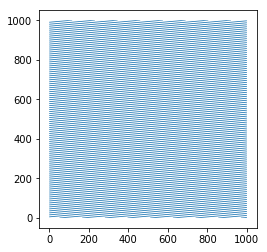

In [55]:
c = coverage.plot()

## Assemblage

### Layer 1

In [56]:
from numpy.random import random
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd

n = 250
xrange=(0, 1000); yrange=(0, 1000)

xs = (random(n) * (xrange[1] - xrange[0])) + xrange[0]
ys = (random(n) * (yrange[1] - yrange[0])) + yrange[0]
gds = gpd.GeoSeries([Point(xy) for xy in zip(xs, ys)])

ceramics = gpd.GeoDataFrame({'layer_name': ['ceramics'] * n,
                           'fid': [f'ceramics_{i}' for i in range(n)],
                           'time_penalty': [0.1] * n,
                           'ideal_obs_rate': [0.95] * n,
                           'geometry': gds},
                          geometry = 'geometry'
                         )
ceramics

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_0,0.1,0.95,POINT (220.1909106692381 30.33520629160369)
1,ceramics,ceramics_1,0.1,0.95,POINT (173.9401613220002 477.6391906017471)
2,ceramics,ceramics_2,0.1,0.95,POINT (205.3273722951069 955.8458388542912)
3,ceramics,ceramics_3,0.1,0.95,POINT (652.1782532241202 801.228865988117)
4,ceramics,ceramics_4,0.1,0.95,POINT (914.7298224118836 52.03557742835662)
5,ceramics,ceramics_5,0.1,0.95,POINT (724.9544556498279 74.03935563119678)
6,ceramics,ceramics_6,0.1,0.95,POINT (893.1972802845543 254.6214629424135)
7,ceramics,ceramics_7,0.1,0.95,POINT (474.7898733570469 984.9863788902574)
8,ceramics,ceramics_8,0.1,0.95,POINT (683.3943970083631 92.85982627918843)
9,ceramics,ceramics_9,0.1,0.95,POINT (50.83943969540672 268.0512397004857)


### Layer 2

In [57]:
n = 200
xrange=(0, 1000); yrange=(0, 1000)

xs = (random(n) * (xrange[1] - xrange[0])) + xrange[0]
ys = (random(n) * (yrange[1] - yrange[0])) + yrange[0]
gds = gpd.GeoSeries([Point(xy) for xy in zip(xs, ys)])

lithics = gpd.GeoDataFrame({'layer_name': ['lithics'] * n,
                           'fid': [f'lithics_{i}' for i in range(n)],
                           'time_penalty': [0.15] * n,
                           'ideal_obs_rate': [0.80] * n,
                           'geometry': gds},
                          geometry = 'geometry'
                         )
lithics

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,lithics,lithics_0,0.15,0.8,POINT (589.9115790174069 637.568814673412)
1,lithics,lithics_1,0.15,0.8,POINT (921.4723810040895 309.1391153300916)
2,lithics,lithics_2,0.15,0.8,POINT (90.33677873322654 250.1454892299907)
3,lithics,lithics_3,0.15,0.8,POINT (303.2856819300673 226.0057769406158)
4,lithics,lithics_4,0.15,0.8,POINT (100.6883671368767 172.3604813486331)
5,lithics,lithics_5,0.15,0.8,POINT (455.9499688172129 255.8162715688376)
6,lithics,lithics_6,0.15,0.8,POINT (883.6135795102286 639.8739755230069)
7,lithics,lithics_7,0.15,0.8,POINT (98.39854167810991 268.7440853011517)
8,lithics,lithics_8,0.15,0.8,POINT (602.8937068327194 21.89867781667621)
9,lithics,lithics_9,0.15,0.8,POINT (564.9102073994637 85.24149901180245)


In [58]:
assemblage = pd.concat([ceramics, lithics], ignore_index=True)
assemblage

,layer_name,fid,time_penalty,ideal_obs_rate,geometry
0,ceramics,ceramics_0,0.10,0.95,POINT (220.1909106692381 30.33520629160369)
1,ceramics,ceramics_1,0.10,0.95,POINT (173.9401613220002 477.6391906017471)
2,ceramics,ceramics_2,0.10,0.95,POINT (205.3273722951069 955.8458388542912)
3,ceramics,ceramics_3,0.10,0.95,POINT (652.1782532241202 801.228865988117)
4,ceramics,ceramics_4,0.10,0.95,POINT (914.7298224118836 52.03557742835662)
5,ceramics,ceramics_5,0.10,0.95,POINT (724.9544556498279 74.03935563119678)
6,ceramics,ceramics_6,0.10,0.95,POINT (893.1972802845543 254.6214629424135)
7,ceramics,ceramics_7,0.10,0.95,POINT (474.7898733570469 984.9863788902574)
8,ceramics,ceramics_8,0.10,0.95,POINT (683.3943970083631 92.85982627918843)
9,ceramics,ceramics_9,0.10,0.95,POINT (50.83943969540672 268.0512397004857)


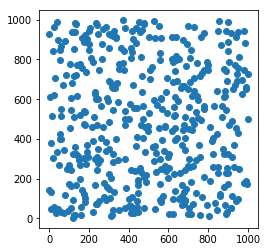

In [59]:
assemblage.plot()

## Team

In [60]:
import pandas as pd

team = pd.DataFrame({'surveyor_type': ['pi', 'grad', 'undergrad', 'undergrad', 'undergrad'],
                     'skill': [1.0, 0.95, 0.85, 0.85, 0.85],
                     'speed_penalty': [0.0, 0.0, 0.2, 0.2, 0.2]
                    })

for stype in team['surveyor_type'].unique():
    stype_df = team.loc[team['surveyor_type']==stype, :]
    team.loc[stype_df.index, 'sid'] = [i for i in range(stype_df.shape[0])]

team['sid'] = team.apply(lambda x: x['surveyor_type'] + '_' + str(int(x['sid'])), axis=1)
team = team.loc[:, ['sid', 'surveyor_type', 'skill', 'speed_penalty']]
team

,sid,surveyor_type,skill,speed_penalty
0,pi_0,pi,1.00,0.0
1,grad_0,grad,0.95,0.0
2,undergrad_0,undergrad,0.85,0.2
3,undergrad_1,undergrad,0.85,0.2
4,undergrad_2,undergrad,0.85,0.2


In [61]:
team

,sid,surveyor_type,skill,speed_penalty
0,pi_0,pi,1.00,0.0
1,grad_0,grad,0.95,0.0
2,undergrad_0,undergrad,0.85,0.2
3,undergrad_1,undergrad,0.85,0.2
4,undergrad_2,undergrad,0.85,0.2


## Putting it all together

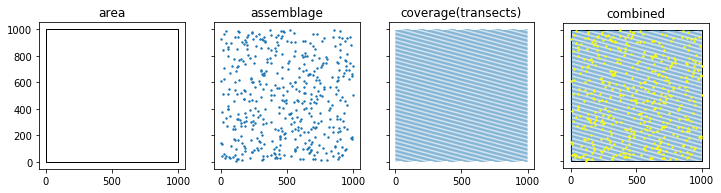

In [80]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, figsize=(12, 3))
area1.plot(ax=ax1, edgecolor='black', color='white').set_title('area')
assemblage.plot(ax=ax2, markersize=2).set_title('assemblage')
coverage.plot(ax=ax3).set_title('coverage(transects)')
area1.plot(ax=ax4, edgecolor='black', color='white')
coverage.plot(ax=ax4)
assemblage.plot(ax=ax4, color='yellow', markersize=2).set_title('combined');

In [ ]:
# allocate surveyors to transects

In [ ]:
# find which artifacts intersect which transect

In [ ]:
# apply visibility factor

In [ ]:
# apply ideal_obs_rate

In [ ]:
# apply surveyor skill

In [ ]:
# add time based on surveyor speed

In [ ]:
# add time penalty for finds to transect

In [ ]:
# compare assemblage to finds